In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
start = '2012-01-01'
end = '2022-12-21'
stock = 'GOOG'

data = yf.download(stock, start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
data.reset_index(inplace=True)

In [6]:
data

Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2012-01-03,16.495001,16.562924,16.171749,16.185880,147611217
1,2012-01-04,16.566149,16.614984,16.376264,16.485584,114989399
2,2012-01-05,16.336348,16.459302,16.267433,16.413690,131808205
3,2012-01-06,16.113497,16.360893,16.107794,16.339821,108119746
4,2012-01-09,15.430305,16.038633,15.399813,16.026237,233776981
...,...,...,...,...,...,...
2756,2022-12-14,94.860695,96.761695,93.497158,95.089614,26452900
2757,2022-12-15,90.770073,93.586734,90.003706,93.099046,28298800
2758,2022-12-16,90.431671,91.317475,89.585680,90.770065,48485500


In [7]:
ma_100_days = data.Close.rolling(100).mean()

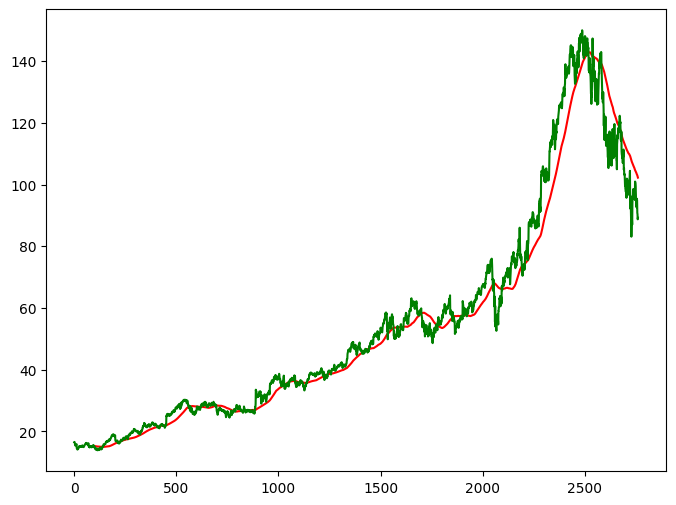

In [8]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()